In [1]:
import numpy as np
from utils import es 
from utils import itd
from utils import prob

import pickle as pkl

import matplotlib.pyplot as plt
%matplotlib inline

from python_speech_features import logfbank

from scipy.io import wavfile
import re
from scipy import stats
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import gammamix

from collections import OrderedDict
import itertools
from scipy.ndimage.filters import gaussian_filter
from tqdm import tqdm_notebook as tqdm

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import os
import tables

import keras
import keras.backend as K
from keras.models import load_model
import sys
import keras
from keras.layers import Dense, Dropout, Activation, BatchNormalization, LSTM, Bidirectional, TimeDistributed
from keras.regularizers import l2

import seaborn as sns
from spike_features import spike_count_features_by_time

/home/enea/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Some routines

In [2]:
def remove_trigger(timestamps, addresses):
    dx = 0.000001
    idx =  np.argmax(np.diff(timestamps)/dx)
    return timestamps[idx + 1:], addresses[idx + 1:]

def wind_sp(ts, ch, w=0.005, limit=False, noise=False):
    ts_int = (ts // w).astype('int32')
    if len(ts_int) < 1:
        ts_int = np.array([0,0])

    A = np.zeros((np.max(ts_int) + 1, 64))
    if noise:
        A += np.abs(np.random.randn(A.shape[0], A.shape[1]))

    for _t, _c in zip(ts_int, ch):
        A[_t, _c] += 1
        
    if limit:
        A = np.minimum(A, np.ones_like(A))
    # returning [ch, T]
    return A.T

def wind_sp2(ts, ch, w=0.005, limit=False, noise=False):
    ts -= np.min(ts)
    ts_int = (ts // w).astype('int32')
    if len(ts_int) < 1:
        ts_int = np.array([0,0])

    A = np.zeros((np.max(ts_int) + 1, 64))
    if noise:
        A += np.abs(np.random.randn(A.shape[0], A.shape[1]))

    for _t, _c in zip(ts_int, ch):
        A[_t, _c] += 1
        
    if limit:
        A = np.minimum(A, np.ones_like(A))
    # returning [ch, T]
    return A.T

def exp_feat(A, win=0.05, tpe='lap', l=300):
    if tpe == 'exp':
        t = np.arange(0, win, 0.001)
        b = np.exp(-l * t)
    elif tpe == 'lap':
        t = np.arange(-win, win, 0.001)
        b = np.exp(-l * np.abs(t))
        
    b /= np.linalg.norm(b)
    AA = np.array([np.convolve(_a, b, 'same') for _a in A])
    return AA

def smear_fr(A, win=3, l=10):
#     t = np.arange(-win, win, 1)
#     b = np.exp(-l * np.abs(t))
#     b = np.concatenate([np.arange(win), np.arange(win)[::-1]])
#     A = np.array([np.convolve(_a, b, 'same') for _a in A.T])
    A = gaussian_filter(A, 1)
    return A

def simple_low_pass(X, win=12, shift=8):
#     X = np.concatenate([np.zeros((win, X.shape[1])),X , np.zeros((win, X.shape[1]))], 0)
    n_win = (X.shape[0] - win) // shift
    XX = np.zeros((n_win, X.shape[1]))
    for i in range(0, n_win):
        XX[i] = np.sum(X[i * shift: (i + 1) * shift] , 0) / win
    return XX

def spike_features(T1, C1, limit=False, noise=False):
    A = wind_sp(np.array(T1), np.array(C1).astype('int32'), limit=limit, noise=noise)
#     A = exp_feat(A, win=0.05, l=300, tpe='lap')
    A = smear_fr(A, win=3)
    A = np.log10(A + 1e-9)
    A = simple_low_pass(A.T).T
    return A

def get_ctx_win(X, Y, ctx=5, shift=1):
    n_win = (X.shape[1] - ctx * 2) // shift
    X_re = np.array([X[:, i - ctx:i + ctx + 1].reshape(-1,) for i in range(ctx, n_win * shift, shift)])
    Y_re = Y[:, ctx + 1:-(ctx * 2 - 1)].T
    return X_re, Y_re


def get_ctx_win2(X, Y, ctx=30, shift=1):
    n_win = (X.shape[1] - ctx) // shift
    X_re = np.array([X[:, i:i + ctx] for i in range(ctx, n_win * shift, shift)])
    Y_re = np.array([Y[:, i:i + ctx] for i in range(ctx, n_win * shift, shift)])
    return X_re.transpose(0, 2, 1), Y_re.transpose(0, 2, 1)


def find_local_maxima(x, win=5):
    to_pad = win // 2
    x = np.pad(x, (to_pad,to_pad), 'constant', constant_values=(0, 0))
    idx = []
    for i in range(to_pad, len(x) - to_pad):
        if np.argmax(x[i - to_pad: i + to_pad]) == to_pad:
            idx.append(i - to_pad)
    return np.array(idx)

def correct_pos(pos):
    if pos == 0:
        pos = 1
    if pos == 18:
        pos = 17
    return pos


# SPS

In [3]:
def sps(idx, subset, sigma=20, channels=np.arange(64), adj=-1, verbose=False, fast=False):
    
    filename = basedir + 'aedat/{}/'.format(subset) + ALL_NAMES[subset][IDX] + '.aedat'
    
    # load / trigger / decode
    timestamps, addresses = es.loadaerdat(filename)
    timestamps, addresses = remove_trigger(timestamps, addresses)
    timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)
    neuron_id = neuron_id * 0
    # load wavs
    spk1, spk2, _ = re.compile('[0-9]+').split(ALL_NAMES[subset][IDX])
    _, utt1, utt2 = re.compile('[A-Z]+').split(ALL_NAMES[subset][IDX])
    
    angles = ALL_ANGLES[subset][IDX].split(' ')
    pos1, pos2 = int(float(angles[1])), int(float(angles[2]))
    pos_dict = {0: 0, 30:1, 60:2, 90:3, 120:4, 150:5, 180:6}
    pos = [pos_dict[pos1], pos_dict[pos2]]
    if not fast:
        fs, w1 = wavfile.read(basedir_wav + 'wavs/{}/'.format(subset) + GTS1[subset][IDX].replace('\\', '/') + '.wav')
        fs, w2 = wavfile.read(basedir_wav + 'wavs/{}/'.format(subset) + GTS2[subset][IDX].replace('\\', '/') + '.wav')
    else:
        fs = w1 = w2 = 0
    # get itd and fix them
    total_evs = 0
    _aa = {}
    idx_dict = {}
    for kk in channels:
        indices_channels = np.isin(channel_id, np.array([kk]))
        if kk in DICT_C:
            try:
                _itds, _itd_idx = itd.get_itds(timestamps[indices_channels], ear_id[indices_channels], neuron_id[indices_channels], save_to_file=None,
                                     verbose=False, max_itd=max_itd, return_itd_indices=True)
                idx_dict[kk] = _itd_idx
                total_evs += len(_itds)
                _mu = DICT_C[kk]['mu']
                _corr = (_itds - _mu)
                _aa[kk] = _corr
            except Exception as e:
                print e
        else:
            _itds, _itd_idx = itd.get_itds(timestamps[indices_channels], ear_id[indices_channels], neuron_id[indices_channels], save_to_file=None,
                                     verbose=False, max_itd=max_itd, return_itd_indices=True)
            _aa[kk] = _itds
            idx_dict[kk] = _itd_idx
            total_evs += len(_itds)

    if verbose:
        print "#ENVS {} => RECOVERED {}".format(len(timestamps), total_evs)
    
    # get probabilities
    index_angles = np.vstack([np.arange(7), np.arange(0, 190, 30)]).T
    num_angles = len(PRIORS)
    initial_estimate = np.ones(num_angles) / num_angles # all angles are a priori equally likely
    transition_probabilities = prob.get_transition_probabilities(index_angles, sigma=sigma) # gaussian a priori probability of itds given a certain position
    itd_dict = itd.get_itd_dict(max_itd, num_bins) # array holding the mean values of all itd bins
    
    arg = {}
    all_itds = []
    for k, _a in _aa.iteritems():
        estimates, argmax_estimates = prob.get_estimates(_a, initial_estimate, transition_probabilities, ITD_DICT, PRIORS)
        arg[k] = argmax_estimates
        all_itds.extend(_a)
        
    amax = []
    for k, v in arg.iteritems():
        amax.extend(v)
    amax = np.array(amax)
    
    if verbose:
        print "{} vs {}".format(len(all_itds), len(amax))
    # get separated spikes
    T = []
    C = []
    adj = 1 if np.abs(pos[0] - pos[1]) > 2 else -1
    
    if verbose:
        print adj
    
    for p in pos:
        T1 = []
        C1 = []
        for ch in idx_dict.keys():
            t = (timestamps[channel_id == ch])[idx_dict[ch][arg[ch] == p]]
            T1.extend(t)
            C1.extend(np.ones_like(t) * ch)
            if adj > 0:
                t = (timestamps[channel_id == ch])[idx_dict[ch][arg[ch] == p - 1]]
                T1.extend(t)
                C1.extend(np.ones_like(t) * ch)
                t = (timestamps[channel_id == ch])[idx_dict[ch][arg[ch] == p + 1]]
                T1.extend(t)
                C1.extend(np.ones_like(t) * ch)
        T.append(T1)
        C.append(C1)
    if verbose:
        print "#ENVS 1 {} ({})".format(len(T[0]), len(C[0]))
        print "#ENVS 2 {} ({})".format(len(T[1]), len(C[1]))
    i0 = np.argsort(T[0])
    i1 = np.argsort(T[1])
    return [np.array(T[0])[i0],np.array(T[1])[i1]], [np.array(C[0])[i0].astype('int32'),np.array(C[1])[i1].astype('int32')], w1, w2, fs, amax, pos, timestamps, channel_id, ear_id
    

# Some data preparation

In [4]:
basedir = '/Data/DATASETS/CAESAR_TIDIGITS/aedat7/spikes_7_HV/'
basedir_wav =  '/Data/DATASETS/CAESAR_TIDIGITS/'
num_bins = 80
max_itd = 800e-6
num_channels = 64

ALL_ANGLES = {}
ALL_NAMES = {}

GTS1 = {}
GTS2 = {}

with open(basedir + 'log_train.txt') as t:
    ALL_ANGLES['train'] = [x for x in t.readlines()]

with open(basedir + 'log_test.txt') as t:
    ALL_ANGLES['test'] = [x for x in t.readlines()]

with open('train_set.txt') as t:
    ALL_NAMES['train'] = [line.split(' ')[4].strip() for line in t.readlines()]
with open('train_set.txt') as t:
    GTS1['train'] = [line.split(' ')[0].strip() for line in t.readlines()]
with open('train_set.txt') as t:
    GTS2['train'] = [line.split(' ')[1].strip() for line in t.readlines()]
    
with open('test_set.txt') as t:
    ALL_NAMES['test'] = [line.split(' ')[4].strip() for line in t.readlines()]
with open('test_set.txt') as t:
    GTS1['test'] = [line.split(' ')[0].strip() for line in t.readlines()]
with open('test_set.txt') as t:
    GTS2['test'] = [line.split(' ')[1].strip() for line in t.readlines()]
    
PRIORS = np.load('priors_long_hv_mf_7_corrected_all.npy')
DICT_C = pkl.load(open('correction_dict_mf_7.pkl', 'r'))
ITD_DICT = itd.get_itd_dict(max_itd, num_bins) 

print len(PRIORS)

# for subset in ['train', 'test']:
#     for idx, l in enumerate(ALL_ANGLES[subset]):
#         spk1, spk2, _ = re.compile('[0-9]+').split(l.split(' ')[0])
#         pos1, pos2 = int(float(l.split(' ')[1]) // 10) , int(float(l.split(' ')[2]) // 10)
#         pos1, pos2 = correct_pos(pos1), correct_pos(pos2)
#         if np.abs(pos1 - pos2) > 2:
#             VALID_IDX[subset].append(idx)


7


In [8]:
from collections import OrderedDict
from collections import Counter
SPK_DICT = {}

count = 0
with open('train_set.txt') as t:
    s = [(line.split(' ')[0].strip(), line.split(' ')[0].strip()) for line in t.readlines()]
    for i, (s1, s2) in enumerate(s):
        k = s1.split('\\')[4].strip()
        if k not in SPK_DICT:
            SPK_DICT[k] = count
            count += 1
        k = s2.split('\\')[4].strip()
        if k not in SPK_DICT:
            SPK_DICT[k] = count
            count += 1
with open('test_set.txt') as t:
    s = [(line.split(' ')[0].strip(), line.split(' ')[0].strip()) for line in t.readlines()]
    for i, (s1, s2) in enumerate(s):
        k = s1.split('\\')[4].strip()
        if k not in SPK_DICT:
            SPK_DICT[k] = count
            count += 1
        k = s2.split('\\')[4].strip()
        if k not in SPK_DICT:
            SPK_DICT[k] = count
            count += 1

print len(SPK_DICT.keys())

ALL_SPK = {'train': {'s1': [], 's2': []}, 'test': {'s1': [], 's2': []}}

for subset in ['train', 'test']:
    for idx, l in enumerate(ALL_ANGLES[subset]):
        spk1, spk2, _ = re.compile('[0-9]+').split(l.split(' ')[0])
        ALL_SPK[subset]['s1'].append(SPK_DICT[spk1])
        ALL_SPK[subset]['s2'].append(SPK_DICT[spk2])

ALL_LBL = {'train': [], 'test': []}

for subset in ['train', 'test']:
    for i in range(len(ALL_NAMES[subset])):
        ALL_LBL[subset].append(ALL_SPK[subset]['s1'][i])
        ALL_LBL[subset].append(ALL_SPK[subset]['s2'][i])



225


# Loading example

In [ ]:
IDX = 37
subset = 'train'

ch = np.arange(0,64)
T, C, w1, w2, fs, amax, pos, t, c, e = sps(IDX, subset, sigma=3, channels=ch)
spkf1 = wind_sp2(T[0], C[0], limit=False, noise=False).T
spkf2 = wind_sp2(T[1], C[1], limit=False, noise=False).T
print spkf1.shape
# i0 = np.argsort(T[0])
# i1 = np.argsort(T[1])

# print len(T[1])
# print len(C[1])

# spkf1 = spike_count_features_by_time(np.array(T[0])[i0], np.array(C[0])[i0].astype('int32'))
# spkf2 = spike_count_features_by_time(np.array(T[1])[i1], np.array(C[1])[i1].astype('int32'))


f, ax = plt.subplots(2, 2,figsize=(20, 5))

for spkf, k, w in zip([spkf1, spkf2], range(2), [w1, w2]):
    
    Y = logfbank(w, fs, nfft=2048,winlen=0.06,winstep=0.04)
    ax[0][k].imshow(Y.T, aspect='auto')
    ax[1][k].imshow(spkf.T / (np.std(spkf.T, 1, keepdims=True) + 1e-8), aspect='auto')


# Check precision in localization 

In [ ]:
sys.stdout.flush()
acc = 0.
count = 0.
for IDX in tqdm(range(5999)):
    pos1, pos2 = int(float(all_angles[IDX].split(' ')[1]) // 10) , int(float(all_angles[IDX].split(' ')[2]) // 10)
#     if pos1 != pos2: 
    if np.abs(pos1 - pos2) >= 2:  # non-adiacent or same spot
        p = np.sort([correct_pos(pos1), correct_pos(pos2)])
        ch = np.arange(15,30)
        T, C, w1, w2, fs, amax = sps(basedir + 'aedat/train/' + all_train[IDX] + '.aedat', sigma=5, channels=ch)
        a = np.histogram(amax, 19, range=[0, 18], normed=True)
        ii = find_local_maxima(a[0])
        
        kk = np.sort(ii[np.argsort(a[0][ii])[::-1][:2]])
        if len(kk) == 2:
            if np.abs(p[0] - kk[0]) <= 1 and np.abs(p[1] - kk[1]) <= 1:
                acc += 1.
            count += 1.
print acc / count * 100

# How many are same position or adiacent

In [ ]:
sys.stdout.flush()
idx_0_train = []
idx_1_train = []
idx_0_test = []
idx_1_test = []
acc = 0.
count = 0.
for IDX in range(1999):
    pos1, pos2 = int(float(all_angles_test[IDX].split(' ')[1]) // 10) , int(float(all_angles_test[IDX].split(' ')[2]) // 10)
    pos1, pos2 = correct_pos(pos1), correct_pos(pos2)
    if pos1 == pos2:
        count += 1.
        idx_0_test.append(IDX)

print "TEST: same angle in {:.2} % of the cases ({})".format(count / 1999 * 100, len(idx_0_test))

count = 0.
for IDX in range(5999):
    pos1, pos2 = int(float(all_angles[IDX].split(' ')[1]) // 10) , int(float(all_angles[IDX].split(' ')[2]) // 10)
    pos1, pos2 = correct_pos(pos1), correct_pos(pos2)
    if pos1 == pos2:
        count += 1.
        idx_0_train.append(IDX)
        
print "TRAIN: same angle in {:.3} % of the cases ({})".format(count / 5999 * 100, len(idx_0_train))

sys.stdout.flush()
acc = 0.
count = 0.
for IDX in range(1999):
    
    pos1, pos2 = int(float(all_angles_test[IDX].split(' ')[1]) // 10) , int(float(all_angles_test[IDX].split(' ')[2]) // 10)
    pos1, pos2 = correct_pos(pos1), correct_pos(pos2)
    if np.abs(pos1 - pos2) == 1:
        count += 1.
        idx_1_test.append(IDX)

print "TEST: adiacent angle in {:.2} % of the cases ({})".format(count / 1999 * 100, len(idx_1_test))

count = 0.
for IDX in range(5999):
    pos1, pos2 = int(float(all_angles[IDX].split(' ')[1]) // 10) , int(float(all_angles[IDX].split(' ')[2]) // 10)
    pos1, pos2 = correct_pos(pos1), correct_pos(pos2)
    if np.abs(pos1 - pos2) == 1:
        count += 1.
        idx_1_train.append(IDX)
        
print "TRAIN: adiacent angle in {:.3} % of the cases ({})".format(count / 5999 * 100, len(idx_1_train))

ang_diff_test = []

for IDX in range(1999):
    pos1, pos2 = int(float(all_angles_test[IDX].split(' ')[1]) // 10) , int(float(all_angles_test[IDX].split(' ')[2]) // 10)
    pos1, pos2 = correct_pos(pos1), correct_pos(pos2)
    ang_diff_test.append(np.abs(pos1 - pos2))
    
ang_diff_train = []

for IDX in range(5999):
    pos1, pos2 = int(float(all_angles[IDX].split(' ')[1]) // 10) , int(float(all_angles[IDX].split(' ')[2]) // 10)
    pos1, pos2 = correct_pos(pos1), correct_pos(pos2)
    ang_diff_train.append(np.abs(pos1 - pos2))
    
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
_ = ax.hist(ang_diff_train, 16, normed=True)
ax.set_title('train')
ax = fig.add_subplot(1,2,2)
_ = ax.hist(ang_diff_test, 16, normed=True)
ax.set_title('test')

plt.tight_layout()

# Load and shift correctly

In [ ]:
IDX = 390
subset = 'test'

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_mix.h5'

h5 = tables.open_file(h5file, 'r')
dataset = h5.get_node(os.path.join(os.sep, 'default', subset))

channels = h5.list_nodes(os.path.join(os.sep, 'default', subset))

print ALL_NAMES[subset][IDX]
timestamps, addresses = es.loadaerdat(basedir + 'aedat/{}/'.format(subset) + ALL_NAMES[subset][IDX] + '.aedat')
timestamps, addresses = remove_trigger(timestamps, addresses)

timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

# load wav
spk1, spk2, _ = re.compile('[0-9]+').split(ALL_NAMES[subset][IDX])
_, utt1, utt2 = re.compile('[A-Z]+').split(ALL_NAMES[subset][IDX])
pos1, pos2 = int(float(ALL_ANGLES[subset][IDX].split(' ')[1]) // 10) , int(float(ALL_ANGLES[subset][IDX].split(' ')[2]) // 10)
print pos1
print pos2
fs, w1 = wavfile.read(basedir + 'wavs/{}/'.format(subset) + GTS1[subset][IDX].replace('\\', '/') + '.wav')
fs, w2 = wavfile.read(basedir + 'wavs/{}/'.format(subset) + GTS2[subset][IDX].replace('\\', '/') + '.wav')

fig = plt.figure(figsize=(20,10))
 
ax = fig.add_subplot(2,1,1)

m_len = max([len(w1), len(w2)])
w1 = np.concatenate([w1, np.zeros(m_len - len(w1),)])
w2 = np.concatenate([w2, np.zeros(m_len - len(w2),)])

print m_len

Y = np.reshape(channels[0].features[IDX], channels[0].feature_shape[IDX])[:, :41]

print Y.shape
ax.imshow(Y.T, aspect='auto')
# ax.plot(np.sum(Y, 1) / 400.0 * 20, 'r')
ax.invert_yaxis()

ax = fig.add_subplot(2,1,2)

K = spike_features(timestamps, channel_id)[2:]

env_log = np.sum(Y, 1)
env_sps = np.sum(K, 0)

k = np.correlate(env_log, env_sps, 'full')

shift = np.argmax(np.abs(k)) - len(env_sps)
print shift

ax.imshow(K[::-1, np.abs(shift):], aspect='auto')
# ax.plot(np.sum(K, 0) / 1000.0 * 10 + 20, 'r')
ax.invert_yaxis()

# ax.plot(np.sum(K, 0) / 1000.0 * 25, 'r')
# ax.imshow(np.log10(wind_sp(timestamps, channel_id) + 1e-9), aspect='auto')
# ax.plot(timestamps, channel_id, 'o')
ax.set_xlim([0, Y.shape[0]])
# ax.plot()

fig = plt.figure()
ax = fig.add_subplot(2,1,1)
ax.set_xlim([0, Y.shape[0]])
ax.plot(np.sum(Y, 1) / 400.0 * 20, 'r')
ax = fig.add_subplot(2,1,2)
ax.plot(np.sum(K, 0) / 1000.0 * 10 + 20, 'r')
ax.set_xlim([0, Y.shape[0]])

h5.close()

In [ ]:
IDX = 388
subset = 'test'

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_mix.h5'

h5 = tables.open_file(h5file, 'r')
dataset = h5.get_node(os.path.join(os.sep, 'default', subset))

channels = h5.list_nodes(os.path.join(os.sep, 'default', subset))

print ALL_NAMES[subset][IDX]
timestamps, addresses = es.loadaerdat(basedir + 'aedat/{}/'.format(subset) + ALL_NAMES[subset][IDX] + '.aedat')
plt.plot(timestamps)

# Create dataset with alligned log/spikes

In [ ]:
all_log = {'train': [], 'test': []}
all_spk = {'train': [], 'test': []}

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_mix.h5'

h5 = tables.open_file(h5file, 'r')

channels = h5.list_nodes(os.path.join(os.sep, 'default', 'train'))

for subset in ['train', 'test']:
    print "DOING {}".format(subset)
    channels = h5.list_nodes(os.path.join(os.sep, 'default', subset))
    
    for IDX in tqdm(range(len(ALL_NAMES[subset]))):
        timestamps, addresses = es.loadaerdat(basedir + 'aedat/{}/'.format(subset) + ALL_NAMES[subset][IDX] + '.aedat')
        timestamps, addresses = remove_trigger(timestamps, addresses)

        timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

        Y = np.reshape(channels[0].features[IDX], channels[0].feature_shape[IDX])[:, :41]

        K = spike_features(timestamps, channel_id)[2:]

        env_log = np.sum(Y, 1)
        env_sps = np.sum(K, 0)

        k = np.correlate(env_log, env_sps, 'full')

        shift = np.argmax(np.abs(k)) - len(env_sps)

        K = K[:, np.abs(shift):]
        K = K[:, :Y.shape[0]]
        Y = Y.T

        if K.shape[1] != Y.shape[1]:
            print K.shape
            print Y.shape
            raise ValueError()
        all_log[subset].append(Y)
        all_spk[subset].append(K)


h5.close()

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0][0].imshow(all_spk['train'][3], aspect='auto')
ax[1][0].imshow(all_log['train'][3], aspect='auto')
ax[0][1].imshow(all_spk['test'][3], aspect='auto')
ax[1][1].imshow(all_log['test'][3], aspect='auto')

In [ ]:
pkl.dump({'log': all_log['train'], 'spk': all_spk['train']}, open('all_log_spk_train_v02.pkl', 'w'))
pkl.dump({'log': all_log['test'], 'spk': all_spk['test']}, open('all_log_spk_test_v02.pkl', 'w'))

# Load data and train reconstruction model (MLP) 

In [ ]:
# ds_v = ''  # default
ds_v = '_v02'
print "TRAIN:"
all_mix_log = pkl.load(open('all_log_spk_train{}.pkl'.format(ds_v), 'r'))['log']
print "\tMIX LOG => {}".format(len(all_mix_log))
all_mix_spk = pkl.load(open('all_log_spk_train{}.pkl'.format(ds_v), 'r'))['spk']
print "\tMIX SPK => {}".format(len(all_mix_spk))
print "TEST:"
all_mix_log_test = pkl.load(open('all_log_spk_test{}.pkl'.format(ds_v), 'r'))['log']
print "\tMIX LOG => {}".format(len(all_mix_log_test))
all_mix_spk_test = pkl.load(open('all_log_spk_test{}.pkl'.format(ds_v), 'r'))['spk']
print "\tSPK LOG => {}".format(len(all_mix_spk_test))

# I also use the samples from spk_sep train
ds_v = '_v05'
print "TRAIN:"
all_sep_log = pkl.load(open('all_sep_spk_train{}.pkl'.format(ds_v), 'r'))['log']
print "\tSEP LOG => {}".format(len(all_sep_log))
all_sep_spk = pkl.load(open('all_sep_spk_train{}.pkl'.format(ds_v), 'r'))['spk']
print "\tSEP SPK => {}".format(len(all_sep_spk))
print "TEST:"
all_sep_log_test = pkl.load(open('all_sep_spk_test{}.pkl'.format(ds_v), 'r'))['log']
print "\tSEP LOG => {}".format(len(all_sep_log_test))
all_sep_spk_test = pkl.load(open('all_sep_spk_test{}.pkl'.format(ds_v), 'r'))['spk']
print "\tSEP SPK => {}".format(len(all_sep_spk_test))

In [ ]:
for IDX in tqdm(range(20)):
    f, ax = plt.subplots(2, 2, figsize=(20,10))

    im = ax[0][0].imshow(all_sep_spk[IDX], aspect='auto')
    plt.colorbar(im, ax=ax[0][0])
    im = ax[1][0].imshow(all_sep_log[IDX], aspect='auto')
    plt.colorbar(im, ax=ax[1][0])
    im = ax[0][1].imshow(all_sep_spk_test[IDX], aspect='auto')
    plt.colorbar(im, ax=ax[0][1])
    im = ax[1][1].imshow(all_sep_log_test[IDX], aspect='auto')
    plt.colorbar(im, ax=ax[1][1])

    plt.savefig('./imgs/train/{}_v05.png'.format(IDX))

In [ ]:
# to train I use the all mix plus the separated train
# all_x_train = all_mix_spk + all_mix_spk_test + all_sep_spk
# all_y_train = all_mix_log + all_mix_log_test + all_sep_log
# or only the separated one
all_x_train = all_sep_spk
all_y_train = all_sep_log
# or only the mixed one
# all_x_train = all_mix_spk
# all_y_train = all_mix_log

all_x_test = all_sep_spk_test
all_y_test = all_sep_log_test

Y_train_pre = np.concatenate(all_y_train, 1)
print Y_train_pre.shape
X_train_pre = np.concatenate(all_x_train, 1)
print X_train_pre.shape

Y_test_pre = np.concatenate(all_y_test, 1)
print Y_test_pre.shape
X_test_pre = np.concatenate(all_x_test, 1)
print X_test_pre.shape

## LTD
# Y_train_pre = Y_train_pre[:20]
# Y_test_pre = Y_test_pre[:20]

In [ ]:
ctx = 10
shift = 1
X_train, Y_train = get_ctx_win(X_train_pre, Y_train_pre, ctx=ctx, shift=shift)
print X_train.shape
print Y_train.shape

X_test, Y_test = get_ctx_win(X_test_pre, Y_test_pre, ctx=ctx, shift=shift)
print X_test.shape 
print Y_test.shape

# try to normalize
mean_x = np.mean(X_train, 0)
std_x = np.std(X_train, 0)
mean_y = np.mean(Y_train, 0)
std_y = np.std(Y_train, 0)

# X_train = np.log10(X_train + 1e-9)
# X_test = np.log10(X_test + 1e-9)

# Y_train = np.log10(Y_train + 1e-9)
# Y_test = np.log10(Y_test + 1e-9)

# visually, train vs test
f, ax = plt.subplots(2, 2, figsize=(20,10))

beg = 5200
end = 5300

ax[0][0].imshow(X_test.T[:, beg:end], aspect='auto')
ax[1][0].imshow(Y_test.T[:, beg:end], aspect='auto')

ax[0][1].imshow(X_train.T[:, beg:end], aspect='auto')
ax[1][1].imshow(Y_train.T[:, beg:end], aspect='auto')

# Keras Regression

In [ ]:
model = keras.Sequential()
model.add(Dense(1024, input_shape=(X_train.shape[1],)))
# model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1024))
# model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
# model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
# model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(Y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

# model.summary()

In [ ]:
estop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
mc = keras.callbacks.ModelCheckpoint('./spk2log_mix_v05.h5', monitor='val_loss', save_best_only=True)
results = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, verbose=True, batch_size=256, callbacks=[estop, mc])

In [ ]:
# load model
plt.plot(results.history['loss'], label='Train loss')
plt.plot(results.history['val_loss'], label='Test loss')
plt.legend()
model = load_model('spk2log_mix_v05.h5')

In [ ]:
# visually, train vs test
f, ax = plt.subplots(2, 2, figsize=(20,10))
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

beg = 5200
end = 5300

ax[0][0].imshow(Y_test.T[:, beg:end], aspect='auto')
ax[1][0].imshow(Y_pred_test.T[:, beg:end], aspect='auto')

ax[0][1].imshow(Y_train.T[:, beg:end], aspect='auto')
ax[1][1].imshow(Y_pred_train.T[:, beg:end], aspect='auto')

# Keras Regression v2 (LSTM)

In [ ]:
TS = 30
X_train_lstm, Y_train_lstm = get_ctx_win2(X_train_pre, Y_train_pre, ctx=TS)
X_test_lstm, Y_test_lstm = get_ctx_win2(X_test_pre, Y_test_pre, ctx=TS)

print X_train_lstm.shape
print Y_train_lstm.shape
print X_test_lstm.shape
print Y_test_lstm.shape

In [ ]:
model2 = keras.Sequential()
model2.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model2.add(Bidirectional(LSTM(128, return_sequences=True)))
model2.add(TimeDistributed(Dense(Y_train_lstm.shape[2])))
model2.compile(optimizer='adam', loss='mse')

model2.summary()

In [ ]:
estop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
mc = keras.callbacks.ModelCheckpoint('./spk2log_mix_v03_lstm.h5', monitor='val_loss', save_best_only=True)
results = model2.fit(X_train_lstm, Y_train_lstm, validation_data=(X_test_lstm, Y_test_lstm), epochs=100, verbose=True, batch_size=256, callbacks=[estop, mc])

In [ ]:
# visually, train vs test
f, ax = plt.subplots(2, 2, figsize=(20,10))
Y_pred_train_lstm = model2.predict(X_train_lstm)
Y_pred_test_lstm = model2.predict(X_test_lstm)

beg = 5200
end = 5300

ax[0][0].imshow(Y_test_lstm[13].T, aspect='auto')
ax[1][0].imshow(Y_pred_test_lstm[13].T, aspect='auto')

ax[0][1].imshow(Y_train_lstm[13].T, aspect='auto')
ax[1][1].imshow(Y_pred_train_lstm[13].T, aspect='auto')

# SKLEARN Regression

In [ ]:
lr = MLPRegressor(hidden_layer_sizes=(256, 256), verbose=True, early_stopping=True)
lr.fit(X_train, Y_train)

Y_pred = lr.predict(X_test)

In [ ]:
# pkl.dump(lr, open('mlp_256_256_spk2log.pkl', 'wb'))
lr = pkl.load(open('mlp_256_256_spk2log.pkl', 'r')) 

In [ ]:
Y_pred_train = lr.predict(X_train)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2,1,1)
ax.imshow(Y_train.T[:, 1000:1200], aspect='auto')
ax = fig.add_subplot(2,1,2)
ax.imshow(Y_pred_train.T[:, 1000:1200], aspect='auto')

In [ ]:
Y_pred = lr.predict(X_test)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2,1,1)
ax.imshow(Y_test.T[:, 1000:1200], aspect='auto')
ax = fig.add_subplot(2,1,2)
ax.imshow(Y_pred.T[:, 1000:1200], aspect='auto')

# Single Sample

In [ ]:
# single sample 
regressor = model # lr
IDX = 1001

ex_x = all_sep_spk_test[IDX]
ex_y = all_sep_log_test[IDX]
print ex_x.shape 
print ex_y.shape

ex_x, ex_y = get_ctx_win(ex_x, ex_y, ctx=3, shift=1)
print ex_x.shape 
print ex_y.shape

ex_pred = regressor.predict(ex_x)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(3,1,1)
ax.imshow(ex_y.T, aspect='auto')
ax = fig.add_subplot(3,1,2)
ax.imshow(ex_pred.T, aspect='auto')
ax = fig.add_subplot(3,1,3)
d1 = np.diff(ex_pred, axis=1)
d2 = np.diff(d1, axis=1)
deltas = np.concatenate([ex_pred[:, 2:], d1[:, 1:], d2], axis=1)
ax.imshow(deltas.T, aspect='auto')


## Project all dataset

In [ ]:
# single sample 
regressor = model # lr
ctx = 3
shift = 1
ds_v = '_v02'
all_y = {'train': [], 'test': []}
all_lbl = {'train': pkl.load(open('all_sep_spk_train{}.pkl'.format(ds_v), 'r'))['lbl'], 'test': pkl.load(open('all_sep_spk_test{}.pkl'.format(ds_v), 'r'))['lbl']} 

for task, x, y in zip(['train', 'test'], [all_sep_spk, all_sep_spk_test], [all_sep_log, all_sep_log_test]): 
    for ex_x, ex_y in tqdm(zip(x, y)):
        ex_x, ex_y = get_ctx_win(ex_x, ex_y, ctx=ctx, shift=shift)

        ex_pred = regressor.predict(ex_x)
        all_y[task].append(ex_pred.T)

print len(all_y['train'])
print len(all_lbl['train'])
print len(all_y['test'])
print len(all_lbl['test'])

In [ ]:
# double check
IDX = 1002
f, ax = plt.subplots(2,2)
ax[0][0].imshow(all_y['train'][IDX], aspect='auto')
ax[1][0].imshow(all_sep_log[IDX], aspect='auto')
ax[0][1].imshow(all_y['test'][IDX], aspect='auto')
ax[1][1].imshow(all_sep_log_test[IDX], aspect='auto')

In [ ]:
# save it
ds_v = '_v02'
pkl.dump({'spk': all_y['train'], 'lbl': all_lbl['train']}, open('all_log_prj_train{}.pkl'.format(ds_v), 'w'))
pkl.dump({'spk': all_y['test'], 'lbl': all_lbl['test']}, open('all_log_prj_test{}.pkl'.format(ds_v), 'w'))

## Check what kind of error distribution there is in reconstruction

In [ ]:
regressor = model

# Y_pred = regressor.predict(X_test)
Q_test = (Y_pred_test - Y_test).reshape(-1)

# Y_pred_train = regressor.predict(X_train)
Q_train = (Y_pred_train - Y_train).reshape(-1)

print Q_train.shape

In [ ]:
f, ax = plt.subplots(1, 2)
# test error distribution

a = ax[0].hist(Q_train, 100, normed=True)
xt = a[1]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(Q_train))

# gaussian
an, bn = stats.norm.fit(Q_train)  
pdf_norm = stats.norm.pdf(lnspc, an, bn)  
ax[0].plot(lnspc, pdf_norm, label="Gaussian")

# laplace
al, bl = stats.laplace.fit(Q_train)  
pdf_laplace = stats.laplace.pdf(lnspc, al, bl)  
ax[0].plot(lnspc, pdf_laplace, label="Laplace")

# gamma
ag, bg, cg = stats.gamma.fit(Q_train)  
pdf_gamma = stats.gamma.pdf(lnspc, ag, bg, cg)  
ax[0].plot(lnspc, pdf_gamma, label="Gamma")

ax[0].legend()

a = ax[1].hist(Q_test, 100, normed=True)
xt = a[1]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(Q_test))

# gaussian
an, bn = stats.norm.fit(Q_test)  
pdf_norm = stats.norm.pdf(lnspc, an, bn)  
ax[1].plot(lnspc, pdf_norm, label="Gaussian")

# laplace
al, bl = stats.laplace.fit(Q_test)  
pdf_laplace = stats.laplace.pdf(lnspc, al, bl)  
ax[1].plot(lnspc, pdf_laplace, label="Laplace")

# laplace
ag, bg, cg = stats.gamma.fit(Q_test)  
pdf_gamma = stats.gamma.pdf(lnspc, ag, bg, cg)  
ax[1].plot(lnspc, pdf_gamma, label="Gamma")

ax[1].legend()

In [ ]:
mu, sigma = stats.norm.fit(Q_test)  
pdf_norm = stats.norm.pdf(lnspc, mu, sigma)  
plt.plot(lnspc, pdf_norm, label="Gaussian")

y = np.random.normal(size=100000) * sigma + mu
_ = plt.hist(y, 100, normed=True, label='numpy', alpha=0.5)

print mu
print sigma

In [ ]:
# plot normed histogram
plt.hist(Q.reshape(-1), 100, normed=True)

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(Q.reshape(-1)))
# exactly same as above
ag,bg = stats.laplace.fit(Q.reshape(-1))  
pdf_laplace = stats.laplace.pdf(lnspc, ag, bg)  
plt.plot(lnspc, pdf_laplace, label="Laplace")


# Single separation and reconstrucion

In [ ]:
IDX = 100
subset = 'train'
ctx = 5
shift = 1

T, C, w1, w2, fs, _, amax = sps(IDX, subset, sigma=5)

spkf1 = spike_features(T[0], C[0])[2:]
spkf2 = spike_features(T[1], C[1])[2:]

ex_x = spkf1[::-1]
ex_y = w1

n_win = (ex_x.shape[1] - ctx * 2) // shift

ex_x = np.array([ex_x[:, i - ctx:i + ctx + 1].reshape(-1,) for i in range(ctx, n_win * shift, shift)])
print ex_x.shape 
ex_y = ex_y[:, ctx + 1:-(ctx * 2 - 1)].T
print ex_y.shape


ex_pred = lr.predict(ex_x)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2,1,1)
ax.imshow(ex_y.T, aspect='auto')
ax = fig.add_subplot(2,1,2)
ax.imshow(ex_pred.T, aspect='auto')


In [ ]:
plt.plot(VALID_IDX['train'])

# Process SPS and save

In [ ]:
import gc
gc.disable()
from twilio.rest import Client
client = Client("ACa5636b5b88891fc0789fe740f6d94d8a", "2194cba7f961a8b9cdd687040c050514")
FROM = "+18482510673"
TO = "+16094015565"
# print '',
# sys.stdout.flush()
all_sep_spk = {'train': [], 'test': []}
all_sep_log = {'train': [], 'test': []}
all_label = {'train': [], 'test': []}

ds_v = '_v07'
valid_idx_07 = []
ALL_T = []
ALL_C = []

# h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_sep.h5'

# h5 = tables.open_file(h5file, 'r')

for subset in ['train', 'test']:
    
#     channels = h5.list_nodes(os.path.join(os.sep, 'default', subset))
    
#     for IDX in tqdm(range(len(ALL_NAMES[subset]))):
#         if IDX in VALID_IDX[subset]:
    for IDX in tqdm(VALID_IDX[subset]):
        
        T, C = sps_fast(IDX, subset, sigma=3, adj=1)
        
        _, utt1, utt2 = re.compile('[A-Z]+').split(ALL_NAMES[subset][IDX])
        all_label[subset].append(utt1)
        all_label[subset].append(utt2)
        if IDX % 500 == 0:
            client.messages.create(to=TO, from_=FROM, body="SPS: Doing {} of subset {}".format(IDX, subset))

        for i in range(2):
            
            if len(T) > 0 and len(T[i]) > 10:
                ALL_T.append(T[i])
                ALL_C.append(C[i])
                K = spike_count_features_by_time(np.array(T[i]), np.array(C[i]).astype('int32')).T
    #                 K = spike_features(T[i], C[i], limit=False)[2:]
    #                 Y = np.reshape(channels[0].features[idx], channels[0].feature_shape[idx])[:, :41].T

    #                 env_log = np.sum(Y, 0)
    #                 env_sps = np.sum(K, 0)

    #                 k = np.correlate(env_log, env_sps, 'full')
    #                 shift = np.argmax(np.abs(k)) - len(env_log)

    #                 K = K[:, np.abs(shift):]
    #                 K = K[:, :Y.shape[1]]
                all_sep_spk[subset].append(K)
    #                 all_sep_log[subset].append(Y)
                valid_idx_07.append(IDX)

In [ ]:
import gc
gc.disable()
import sys
sys.stdout.flush()
from twilio.rest import Client
client = Client("ACa5636b5b88891fc0789fe740f6d94d8a", "2194cba7f961a8b9cdd687040c050514")
FROM = "+18482510673"
TO = "+16094015565"
# print '',
# sys.stdout.flush()
all_sep_spk = {'train': [], 'test': []}
all_sep_log = {'train': [], 'test': []}
all_label = {'train': [], 'test': []}

ds_v = '_v07'

ALL_T = {'train': [], 'test': []}
ALL_C = {'train': [], 'test': []}

# h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_sep.h5'

# h5 = tables.open_file(h5file, 'r')

for subset in ['train', 'test']:
    for IDX in tqdm(range(len(ALL_NAMES[subset]))):
        
        T, C, _, _, _, _, _, _, _, _ = sps(IDX, subset, sigma=3, fast=True)
        
        _, utt1, utt2 = re.compile('[A-Z]+').split(ALL_NAMES[subset][IDX])
        all_label[subset].append(utt1)
        all_label[subset].append(utt2)
        if IDX % 500 == 0 and IDX != 0:
            client.messages.create(to=TO, from_=FROM, body="SPS: Doing {} of subset {}".format(IDX, subset))
        for i in range(2):
            ALL_T[subset].append(T[i])
            ALL_C[subset].append(C[i])
            
            K = wind_sp(T[i], C[i], limit=True)[::-1]
            all_sep_spk[subset].append(K)


In [ ]:
import gc
gc.disable()
import sys
sys.stdout.flush()
from twilio.rest import Client
client = Client("ACa5636b5b88891fc0789fe740f6d94d8a", "2194cba7f961a8b9cdd687040c050514")
FROM = "+18482510673"
TO = "+16094015565"
# print '',
# sys.stdout.flush()
all_sep_spk_new = {'train': [], 'test': []}

ds_v = '_v07'

for subset in ['train', 'test']:
    for IDX in tqdm(range(len(ALL_NAMES[subset]))):
        for i in [IDX * 2, IDX * 2 + 1]:
            t = ALL_T[subset][i]
            c = ALL_C[subset][i]
            if len(t) > 0:
                K = wind_sp2(t, c)[::-1]
                if K.shape[1] > 12:
                    K = simple_low_pass(K.T).T
                    K /= (np.std(K, 1, keepdims=True) + 1e-8)
                    if not np.isnan(np.mean(K)):
                        all_sep_spk_new[subset].append(K)
                    else:
                        print "{} / {}".format(subset, IDX)
                        all_sep_spk_new[subset].append(np.random.rand(64, 50))
                else:
                    print "{} / {}".format(subset, IDX)
                    all_sep_spk_new[subset].append(np.random.rand(64, 50))
            else:
                print "{} / {}".format(subset, IDX)
                all_sep_spk_new[subset].append(np.random.rand(64, 50))


In [ ]:
print ds_v
print len(ALL_T['train'])
print len(ALL_C['train'])
print len(all_label['train'])
print len(all_label['test'])

In [ ]:
print len(all_sep_spk_new['test'])
print len(all_sep_spk_new['train'])

In [ ]:
import pickle as pkl
pkl.dump({'T': ALL_T['train']}, open('all_T_v7_train.pkl', 'w'))
pkl.dump({'C': ALL_C['train']}, open('all_C_v7_train.pkl', 'w'))
pkl.dump({'T': ALL_T['test']}, open('all_T_v7_test.pkl', 'w'))
pkl.dump({'C': ALL_C['test']}, open('all_C_v7_test.pkl', 'w'))

In [ ]:
pkl.dump({'spk': all_sep_spk_new['train'], 'lbl': all_label['train']}, open('all_sep_spk_train_777_{}.pkl'.format(ds_v), 'w'))
pkl.dump({'spk': all_sep_spk_new['test'], 'lbl': all_label['test']}, open('all_sep_spk_test_777_{}.pkl'.format(ds_v), 'w'))

In [ ]:
min_ = 1e30
max_ = 0
for subset in ['train', 'test']:
    for i in range(len(all_sep_spk_new[subset])):
        A = all_sep_spk_new[subset][i]
        A /= np.max(A)
        all_sep_spk_new[subset][i] = A
        max_ = max(max_, np.max(A))
        min_ = min(min_, np.min(A))
        if np.isnan(np.mean(A)) or np.mean(A) == 0:
            print "{} / {} / {}".format(subset, i, np.mean(A))

In [9]:
ds_v = '_v07'
print "TRAIN:"
all_sep_spk = pkl.load(open('all_sep_spk_train_777_{}.pkl'.format(ds_v), 'r'))['spk']
print "\tSEP SPK => {}".format(len(all_sep_spk))
print "TEST:"
all_sep_spk_test = pkl.load(open('all_sep_spk_test_777_{}.pkl'.format(ds_v), 'r'))['spk']
print "\tSEP SPK => {}".format(len(all_sep_spk_test))

TRAIN:
	SEP SPK => 12000
TEST:
	SEP SPK => 4000


In [ ]:
pkl.dump({'log': all_sep_log, 'spk': all_sep_spk, 'lbl': all_label['train']}, open('all_sep_spk_train{}.pkl'.format(ds_v), 'w'))

(64, 58)


NameError: name 'all_label' is not defined

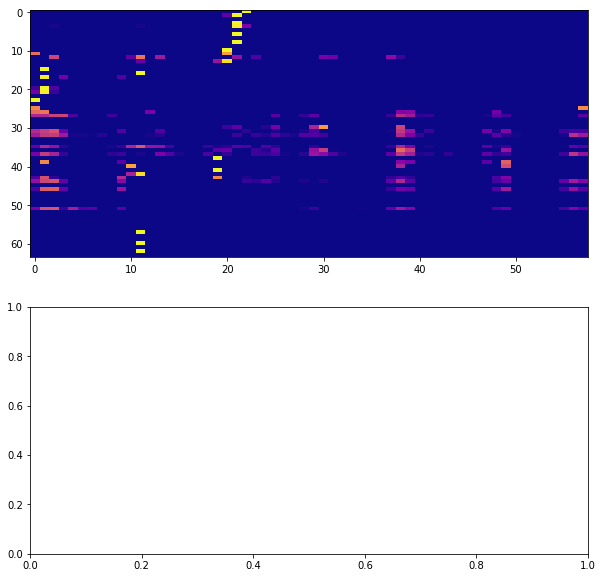

In [10]:
subset = 'train'
IDX = 325
f, ax = plt.subplots(2, 1, figsize=(10,10))

B = all_sep_spk[IDX * 2 + 1]
A = all_sep_spk[IDX * 2]
print(A.shape)
im1 = ax[0].imshow(A , aspect='auto',cmap=plt.get_cmap('plasma'))
ax[0].set_title(all_label[subset][IDX * 2])
plt.colorbar(im1, ax=ax[0])
# ax[1][0].imshow(all_sep_log[subset][IDX * 2], aspect='auto')
im2 = ax[1].imshow(B, aspect='auto',cmap=plt.get_cmap('plasma'))
ax[1].set_title(all_label[subset][IDX * 2 + 1])
# ax[1][1].imshow(all_sep_log[subset][IDX * 2 + 1], aspect='auto')
plt.colorbar(im2, ax=ax[1])
plt.tight_layout()

In [ ]:
subset = 'train'
IDX = 3
f, ax = plt.subplots(2, 1, figsize=(10,10))

B = simple_low_pass(all_sep_spk_new[subset][IDX * 2 + 1].T).T
A = simple_low_pass(all_sep_spk_new[subset][IDX * 2].T).T
print(A.shape)
im1 = ax[0].imshow(A / (np.std(A, 1, keepdims=True) + 1e-8), aspect='auto',cmap=plt.get_cmap('plasma'))
ax[0].set_title(all_label[subset][IDX * 2])
plt.colorbar(im1, ax=ax[0])
# ax[1][0].imshow(all_sep_log[subset][IDX * 2], aspect='auto')
im2 = ax[1].imshow(B / (np.std(B, 1, keepdims=True) + 1e-8), aspect='auto',cmap=plt.get_cmap('plasma'))
ax[1].set_title(all_label[subset][IDX * 2 + 1])
# ax[1][1].imshow(all_sep_log[subset][IDX * 2 + 1], aspect='auto')
plt.colorbar(im2, ax=ax[1])
plt.tight_layout()

In [ ]:
fixer = []
IDX = VALID_IDX['train'][55]
subset = 'train'
h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_sep.h5'
h5 = tables.open_file(h5file, 'r')
log_sep = h5.list_nodes(os.path.join(os.sep, 'default', subset))

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_mix.h5'
h5 = tables.open_file(h5file, 'r')
log_mix = h5.list_nodes(os.path.join(os.sep, 'default', subset))

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_spk_mix.h5'
h5 = tables.open_file(h5file, 'r')
spk_mix = h5.list_nodes(os.path.join(os.sep, 'default', subset))

f, ax = plt.subplots(2, 3, figsize=(20,10))
T, C, w1, w2, fs, _, pos = sps(IDX, subset, sigma=3)
_, utt1, utt2 = re.compile('[A-Z]+').split(ALL_NAMES[subset][IDX])
        
ax[0][2].imshow(np.reshape(spk_mix[0].features[IDX], spk_mix[0].feature_shape[IDX]).T, aspect='auto')
ax[1][2].imshow(np.reshape(log_mix[0].features[IDX], log_mix[0].feature_shape[IDX])[:, :41].T, aspect='auto')

for i, utt, idx, p in zip([0, 1], [utt1, utt2], [IDX * 2, IDX * 2 + 1], pos):
    K = spike_features(T[i], C[i])[2:]
    Y = np.reshape(log_sep[0].features[idx], log_sep[0].feature_shape[idx])[:, :41].T
    env_log = np.sum(Y, 0)
    env_sps = np.sum(K, 0)
    k = np.correlate(env_log, env_sps, 'full')
    shift = np.argmax(np.abs(k)) - len(env_sps)
    K = K[:, np.abs(shift):]
    K = K[:, :Y.shape[1]]
    ax[0][i].imshow(K, aspect='auto')
    ax[0][i].set_title(utt + " - " + str(p * 10))
    ax[1][i].imshow(Y, aspect='auto')
    fixer.append(K)

In [ ]:
all_sep_spk = {'train': []}
all_sep_log = {'train': []}
all_label = {'train': []}

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_spk_sep.h5'
h5 = tables.open_file(h5file, 'r')
spk = h5.list_nodes(os.path.join(os.sep, 'default', 'train'))

h5file2 = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_sep.h5'
h52 = tables.open_file(h5file2, 'r')
log = h52.list_nodes(os.path.join(os.sep, 'default', 'train'))

for idx in range(len(ALL_NAMES['train'])):
    _, utt1, utt2 = re.compile('[A-Z]+').split(ALL_NAMES['train'][idx])
    all_label['train'].append(utt1)
    all_label['train'].append(utt2)

for idx in range(len(log[0].features)):

    Y = np.reshape(spk[0].features[idx], spk[0].feature_shape[idx]).T
    all_sep_spk['train'].append(Y)
    
    Y = np.reshape(log[0].features[idx], log[0].feature_shape[idx])[:, :41].T
    all_sep_log['train'].append(Y)
    

In [ ]:
print len(all_sep_spk['train'])
print len(all_sep_log['train'])
print len(all_label['train'])

In [ ]:
pkl.dump({'log': all_sep_log['train'], 'spk': all_sep_spk['train'], 'lbl': all_label['train']}, open('all_sep_spk_train.pkl', 'w'))


In [ ]:
d_test = pkl.load(open('all_sep_spk_test.pkl', 'r'))

d_test['spk'][388 * 2] = fixer[0]
d_test['spk'][388 * 2 + 1] = fixer[1]

all_sep_spk = {'test': d_test['spk']}
all_sep_log = {'test': d_test['log']}
all_label = {'test': d_test['lbl']}
pkl.dump({'log': all_sep_log['test'], 'spk': all_sep_spk['test'], 'lbl': all_label['test']}, open('all_sep_spk_test.pkl', 'w'))

# VERBOSE

In [ ]:
fixer = []
IDX = 10
subset = 'train'
h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_sep.h5'
h5 = tables.open_file(h5file, 'r')
log_sep = h5.list_nodes(os.path.join(os.sep, 'default', subset))

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_mix.h5'
h5 = tables.open_file(h5file, 'r')
log_mix = h5.list_nodes(os.path.join(os.sep, 'default', subset))

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_spk_mix.h5'
h5 = tables.open_file(h5file, 'r')
spk_mix = h5.list_nodes(os.path.join(os.sep, 'default', subset))

f, ax = plt.subplots(3, 3, figsize=(20,10))
T, C, w1, w2, fs, amax, pos, t, c, e = sps(IDX, subset, sigma=3, verbose=True)
_, utt1, utt2 = re.compile('[A-Z]+').split(ALL_NAMES[subset][IDX])
        
ax[0][2].imshow(np.reshape(spk_mix[0].features[IDX + 1], spk_mix[0].feature_shape[IDX + 1]).T, aspect='auto', cmap=plt.get_cmap('inferno'))
ax[1][2].imshow(np.reshape(log_mix[0].features[IDX + 1], log_mix[0].feature_shape[IDX + 1])[:, :41].T, aspect='auto', cmap=plt.get_cmap('inferno'))

for i, utt, idx, p in zip([0, 1], [utt1, utt2], [IDX * 2, IDX * 2 + 1], pos):
    K = spike_features(np.array(T[i]), np.array(C[i]).astype('int32'))
    Y = np.reshape(log_sep[0].features[idx + 1], log_sep[0].feature_shape[idx + 1])[:, :41].T
    env_log = np.sum(Y, 0)
    env_sps = np.sum(K, 0)
    
    env_log2 = np.hstack([env_log, np.zeros((len(env_sps) - len(env_log),))])
    d1 = np.correlate(env_log2 - np.mean(env_log2), env_sps - np.mean(env_sps), 'full') 
    shift = np.argmax(np.abs(d1)) - len(env_sps)
    
    K = K[:, np.abs(shift):]
    K = K[:, :Y.shape[1]]
    ax[2][i].plot(T[i], C[i], 'o')
    ax[0][i].imshow(K[::-1], aspect='auto')
    ax[0][i].set_title(utt + " - " + str(p * 10))
    ax[1][i].imshow(Y, aspect='auto')
    fixer.append(K)

a = ax[2][2].hist(amax, bins=range(19), normed=True, label='amax', alpha=0.5)
ax[2][2].plot([pos[0] + 0.5, pos[0] + 0.5], [0, a[0][pos[0]]], label='pos0', linewidth=5)
ax[2][2].plot([pos[1] + 0.5, pos[1] + 0.5], [0, a[0][pos[1]]], label='pos1', linewidth=5)
_ = ax[2][2].legend()

In [ ]:
# plt.plot(env_log)
# plt.figure()
# plt.plot(env_sps[:80])
env_log2 = np.hstack([env_log, np.zeros((len(env_sps) - len(env_log),))])

d1 = np.correlate(env_log2 - np.mean(env_log2), env_sps - np.mean(env_sps), 'full') 
plt.plot(d1)
shift = np.argmax(np.abs(d1)) - len(env_sps)
print shift

In [ ]:
fixer = []
IDX = 6
subset = 'train'
h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_sep.h5'
h5 = tables.open_file(h5file, 'r')
log_sep = h5.list_nodes(os.path.join(os.sep, 'default', subset))

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_log_mix.h5'
h5 = tables.open_file(h5file, 'r')
log_mix = h5.list_nodes(os.path.join(os.sep, 'default', subset))

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_spk_mix.h5'
h5 = tables.open_file(h5file, 'r')
spk_mix = h5.list_nodes(os.path.join(os.sep, 'default', subset))

f, ax = plt.subplots(3, 3, figsize=(20,10))
T, C, w1, w2, fs, amax, pos = sps(IDX, subset, sigma=3, adj=1, prior='', verbose=True)
_, utt1, utt2 = re.compile('[A-Z]+').split(ALL_NAMES[subset][IDX])
        
ax[0][2].imshow(np.reshape(spk_mix[0].features[IDX], spk_mix[0].feature_shape[IDX]).T, aspect='auto', cmap=plt.get_cmap('inferno'))
ax[1][2].imshow(np.reshape(log_mix[0].features[IDX], log_mix[0].feature_shape[IDX])[:, :41].T, aspect='auto', cmap=plt.get_cmap('inferno'))

for i, utt, idx, p in zip([0, 1], [utt1, utt2], [IDX * 2, IDX * 2 + 1], pos):
    K = spike_count_features_by_time(np.array(T[i]), np.array(C[i]).astype('int32')).T
    Y = np.reshape(log_sep[0].features[idx], log_sep[0].feature_shape[idx])[:, :41].T
    env_log = np.sum(Y, 0)
    env_sps = np.sum(K, 0)
    k = np.correlate(env_log, env_sps, 'full')
    shift = np.argmax(np.abs(k)) - len(env_log)
#     plt.figure()
#     plt.plot(env_log)
#     plt.plot(env_sps)
    print shift
#     K = K[:, np.abs(shift):]
#     K = K[:, :Y.shape[1]]
    ax[2][i].plot(T[i], C[i], 'o')
    ax[0][i].imshow(K[::-1], aspect='auto')
    ax[0][i].set_title(utt + " - " + str(p * 10))
    ax[1][i].imshow(Y, aspect='auto')
    fixer.append(K)

a = ax[2][2].hist(amax, bins=range(19), normed=True, label='amax', alpha=0.5)
ax[2][2].plot([pos[0] + 0.5, pos[0] + 0.5], [0, a[0][pos[0]]], label='pos0', linewidth=5)
ax[2][2].plot([pos[1] + 0.5, pos[1] + 0.5], [0, a[0][pos[1]]], label='pos1', linewidth=5)
_ = ax[2][2].legend()



In [ ]:
K = spike_features(T[0], C[0], limit=True)[2:]
Y = np.reshape(log_sep[0].features[idx], log_sep[0].feature_shape[idx])[:, :41].T
env_log = np.sum(Y, 0)
env_sps = np.sum(K, 0)
k = np.correlate(env_log, env_sps, 'full')
shift = np.argmax(np.abs(k)) - len(env_log)
print shift
plt.figure()
plt.plot(env_log)
plt.figure()
plt.plot(env_sps)

In [ ]:
def wind_sp2(ts, ch, w=0.001, limit=False, noise=False):
    ts_int = (ts // w).astype('int32')
    if len(ts_int) < 1:
        ts_int = np.array([0,0])

    A = np.zeros((np.max(ts_int) + 3000, 64))
    if noise:
        A += np.abs(np.random.randn(A.shape[0], A.shape[1]))

    for _t, _c in zip(ts_int, ch):
        A[_t, _c] += 1
        
    if limit:
        A = np.minimum(A, np.ones_like(A))
    # returning [ch, T]
    return A.T

f, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(T[0], C[0], 'o')
A = spike_features(T[1], C[1])
# A = wind_sp(np.array(T[1]), np.array(C[1]).astype('int32'), limit=True, noise=False)
# A = exp_feat(A, win=0.05, l=30, tpe='lap')
# A = np.log10(A + 1e-9)
# A = simple_low_pass(A.T).T
print A.shape
ax[1].imshow(A, aspect='auto')

# SPK ID

In [17]:
def pad_streams(streams, max_len, bias=0, fill=-1.0):
    returned_streams = []
    for stream in streams:
        num_items = len(stream)
        # First dim is batch size, second is length (going to be overwritten to max)
        size_tuple = stream[0].shape[1:]
        data_tensor = np.ones((num_items, max_len) + size_tuple, dtype='float32') * fill
        mask_tensor = np.zeros((num_items, max_len), dtype='float32')
        for idx, item in enumerate(stream):
            start_offset = 0
            if len(item) <= max_len:
                data_tensor[idx, start_offset:start_offset + len(item)] = item
                mask_tensor[idx, start_offset:start_offset + len(item)] = 1.
            else:
                if len(item) < bias + max_len:
                    data_tensor[idx, start_offset:start_offset + max_len] = item[-max_len:]  # TODO not general
                    mask_tensor[idx, start_offset:start_offset + max_len] = 1.
                else:
                    data_tensor[idx, start_offset:start_offset + max_len] = item[
                                                                            bias:bias + max_len]  # TODO not general
                    mask_tensor[idx, start_offset:start_offset + max_len] = 1.
        returned_streams.append(data_tensor)
        returned_streams.append(mask_tensor)
    return returned_streams

(array([2857., 3800., 3576., 2580., 1673., 1026.,  370.,   93.,   21.,
           4.]),
 array([  1. ,  12.3,  23.6,  34.9,  46.2,  57.5,  68.8,  80.1,  91.4,
        102.7, 114. ]),
 <a list of 10 Patch objects>)

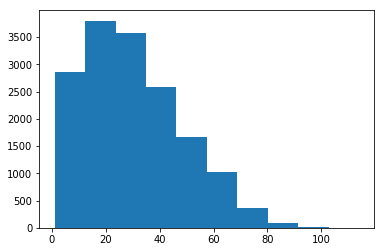

In [59]:
lens = []
for subset in ['train', 'test']:
    for k, v in DATASET[subset].items():
        for _v in v:
            lens.append(_v.shape[0])
plt.hist(lens)

In [60]:
DATASET = {'train': {}, 'test': {}}

for subset, s in zip(['train', 'test'], [all_sep_spk, all_sep_spk_test]):
    keys = ALL_LBL[subset]
    for k, v in zip(keys, s):
        if k not in DATASET[subset]:
            DATASET[subset][k] = []
        DATASET[subset][k].append(v.T)

for subset in ['train', 'test']:
    for k, v in DATASET[subset].iteritems():
        DATASET[subset][k] = pad_streams([np.array(v).T], 80)[0]
# check
print len(DATASET['train'])
print len(DATASET['test'])

112
113


In [61]:
test_keys = DATASET['test'].keys()
for i in range(63):
    k = test_keys[i]
    DATASET['train'][k] = DATASET['test'][k]
    del DATASET['test'][k]

print len(DATASET['train'])
print len(DATASET['test'])

175
50


(116, 80, 64)


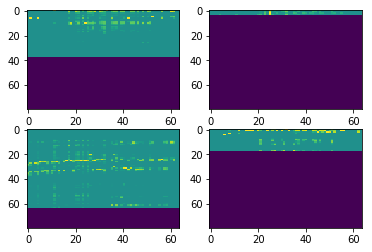

In [63]:
print DATASET['train'][4].shape

f, ax = plt.subplots(2, 2)
ax[0][0].imshow(DATASET['train'][4][0], aspect='auto')
ax[1][0].imshow(DATASET['train'][5][0], aspect='auto')
ax[0][1].imshow(DATASET['train'][6][0], aspect='auto')
ax[1][1].imshow(DATASET['train'][7][0], aspect='auto')

In [64]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D, Masking
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os

import matplotlib.pyplot as plt
from sklearn.utils import shuffle

K.clear_session()

def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (None, 64)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
leg = Sequential()
leg.add(Masking(mask_value=-1.0, input_shape=input_shape))
leg.add(Bidirectional(LSTM(100, return_sequences=True)))
leg.add(Bidirectional(LSTM(100)))
leg.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-6),kernel_initializer=W_init,bias_initializer=b_init))
# leg.add(Dense(512,activation="sigmoid"))

#encode each of the two inputs into a vector with the convnet
encoded_l = leg(left_input)
encoded_r = leg(right_input)
#merge two encoded inputs with the l1 distance between them
both = Lambda(lambda x: K.abs(x[0]-x[1]))([encoded_l,encoded_r])
prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(both)
siamese_net = Model(inputs=[left_input,right_input], outputs=prediction)
#optimizer = SGD(0.0004,momentum=0.6,nesterov=True,decay=0.0003)

optimizer = Adam()
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['acc'])

siamese_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 64)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 64)     0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         1196096     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]               
          

In [67]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, x):
        self.x = x 
        self.classes_train = x['train'].keys()
        self.classes_test = x['test'].keys()

    def get_batch(self, n):
        """Create batch of n pairs, half same class, half different class"""
        categories = rng.choice(self.classes_train, size=(n,), replace=False)
        pairs = [np.zeros((n, 80, 64)) for i in range(2)]
        targets = np.zeros((n,))
        targets[n//2:] = 1
        for i in range(n):
            category = categories[i]
            idx_1 = rng.randint(0, len(self.x['train'][category]))
            pairs[0][i,:,:] = self.x['train'][category][idx_1]
            
            #pick images of same class for 1st half, different for 2nd
            category_2 = category if i >= n//2 else (category + rng.randint(1,len(self.classes_train))) % len(self.classes_train)
            idx_2 = rng.randint(0, len(self.x['train'][category_2]))
            pairs[1][i,:,:] = self.x['train'][category_2][idx_2]
        return pairs, targets

    def make_oneshot_task(self, N):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        categories = rng.choice(self.classes_test, size=(N,), replace=False)
        true_category = categories[0]
        ex1 = rng.randint(0, len(self.x['test'][true_category]))
        
        ex2 = rng.randint(0, len(self.x['test'][true_category]))
        while ex2 == ex1:
            ex2 = rng.randint(0, len(self.x['test'][true_category]))
        
        test_image = np.asarray([self.x['test'][true_category][ex1]]*N).reshape(N, 80, 64)
        
        support_set = np.asarray([self.x['test'][c][rng.randint(0, len(self.x['test'][c]))] for c in categories])
        support_set[0,:,:] = self.x['test'][true_category][ex2]
        
        pairs = [test_image,support_set]
        targets = np.zeros((N,))
        targets[0] = 1
        return pairs, targets

    def test_oneshot(self,model,N,k,verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        pass
        n_correct = 0
        if verbose:
            print("Evaluating model on {} unique {} way one-shot learning tasks ...".format(k,N))
        for i in tqdm(range(k)):
            inputs, targets = self.make_oneshot_task(N)
            probs = model.predict(inputs)
            if np.argmax(probs) == 0:
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct

In [ ]:
evaluate_every = 7000
loss_every = 10
batch_size = 100
N_way = 2
n_val = 550
# siamese_net.load_weights("PATH")
loader = Siamese_Loader(DATASET)

best = 76.0

for i in range(900000):
    (inputs,targets) = loader.get_batch(batch_size)
    loss = siamese_net.train_on_batch(inputs, targets)
    if i % loss_every == 0 and i != 0:
        print("iteration {}, training loss: {:.2f}, training acc: {:.2f}".format(i,loss[0],loss[1]))
    if i % evaluate_every == 0 and i != 0:
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("saving {}".format(val_acc))
            siamese_net.save('PATH')
            best=val_acc



iteration 10, training loss: 0.70, training acc: 0.52
iteration 20, training loss: 0.69, training acc: 0.52
iteration 30, training loss: 0.68, training acc: 0.57
iteration 40, training loss: 0.67, training acc: 0.58
iteration 50, training loss: 0.70, training acc: 0.50
iteration 60, training loss: 0.69, training acc: 0.63
iteration 70, training loss: 0.67, training acc: 0.56
iteration 80, training loss: 0.70, training acc: 0.53
iteration 90, training loss: 0.66, training acc: 0.62
iteration 100, training loss: 0.67, training acc: 0.57
iteration 110, training loss: 0.67, training acc: 0.56
iteration 120, training loss: 0.68, training acc: 0.57
iteration 130, training loss: 0.71, training acc: 0.55
iteration 140, training loss: 0.67, training acc: 0.57
iteration 150, training loss: 0.67, training acc: 0.61
iteration 160, training loss: 0.66, training acc: 0.58
iteration 170, training loss: 0.67, training acc: 0.55
iteration 180, training loss: 0.68, training acc: 0.52
iteration 190, trai